In [55]:
import geopandas as gpd
import pandas as pd
import numpy as np
rng = np.random.default_rng()

import matplotlib.pyplot as plt
from multiprocessing import Pool

#### Chargement des données spatiales

In [2]:
batiment = gpd.read_parquet('BATIMENT_s.parquet')

In [3]:
departement = gpd.read_parquet('DEPARTEMENT.parquet')

Calcul de la part batî occupée dans le département (la vraie valeur) : 

In [176]:
batiment_d = gpd.sjoin(departement, batiment) 
batiment_d = batiment.iloc[batiment_d.index_right]
batiment_d.area.sum() / departement.area.sum() * 100

1.7371116538799352

## Sensibilité au choix de l'origine d'une grille régulière

#### Constitution d'une grille régulière

In [50]:
size = 250 # taille de la grille

In [51]:
xmin = np.floor(departement.bounds.minx.values[0]/size) * size - size
xmax = np.ceil(departement.bounds.maxx.values[0]/size) * size + 2 * size
ymin = np.floor(departement.bounds.miny.values[0]/size) * size - size
ymax = np.ceil(departement.bounds.maxy.values[0]/size) * size + size

In [52]:
x = np.arange(xmin,xmax+size,step=size)
y = np.arange(ymin,ymax+size,step=size)
result = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
df = pd.DataFrame(result, columns=['x', 'y'])

#### Calcul de la sensibilité

In [6]:
def calcul_grille(offset):
    grid = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x+offset[0], df.y+offset[1]), crs="EPSG:2154")
    temp_d = gpd.sjoin(departement, grid)
    temp_b = gpd.sjoin(grid.iloc[temp_d.index_right],batiment_d)
    return([temp_d.shape[0], temp_b.shape[0]])

In [53]:
set_offset = 2 # je décalle la grille de set_offset m en setoffset m 
x_off = np.arange(0,250, set_offset)
y_off = np.arange(0,250, set_offset)
offsets = list(zip(np.tile(x_off,len(y_off)), np.repeat(y_off, len(x_off))))

In [40]:
with Pool(10) as pool: # je paralléliqse les résultats. 
    test = (pool.map(calcul_grille, offsets))

In [41]:
test = pd.DataFrame(np.array(test), columns=['pts_dep', 'pts_build'])

In [42]:
test['x_off'] = [offset[0] for offset in offsets]
test['y_off'] = [offset[1] for offset in offsets]

#### Examen des résultats

In [43]:
test['tx_art'] = test.pts_build / test.pts_dep * 100

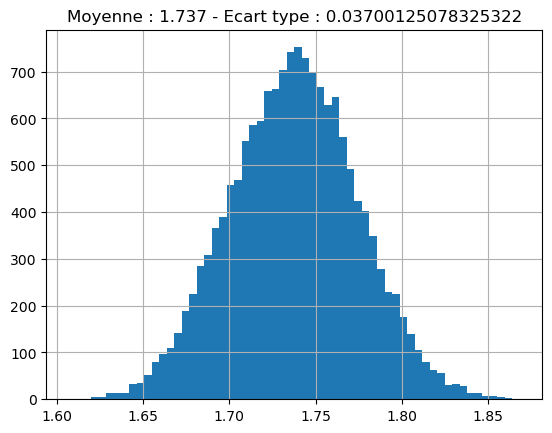

In [72]:
test.hist('tx_art', bins=60)
plt.title('Moyenne : ' + str(np.round(np.mean(test.tx_art),3)) + ' - Ecart type : ' +  str(np.std(test.tx_art)));

In [71]:
test.to_parquet('analyse_2m_bati_31.csv')

## Sensibilité d'un échantillonnage totalement aléatoire

Pour être comparable a l'analyse précédente, le nombre de points (nh) des échantillons est de 101843 (la moyenne des points des grilles dans le département).

In [320]:
nombre_echantillons = 10000

In [321]:
nh = 101843

In [330]:
# Pour obtenir nh points dans le département, je suis obligé dans tirer dans l'envelope (le rectangle englobant du département) 
# puis de restreindre ensuite à l'intersection du département d'où la notion de nh, points dans le département et Nh dans l'envelope
Nh = int((nh / departement.iloc[0,:].geometry.area) * departement.envelope.iloc[0].area * 3) # je multiplie par 3 pour avoir de la marge 

In [323]:
def calcul_aleatoire(seed):
    rng = np.random.default_rng(seed)
    x = rng.uniform(departement.bounds.minx.values[0],departement.bounds.maxx.values[0],Nh) 
    y = rng.uniform(departement.bounds.miny.values[0],departement.bounds.maxy.values[0],Nh) 
    df = pd.DataFrame({'x':x, 'y':y})
    grid = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y), crs="EPSG:2154")
    temp_d = gpd.sjoin(departement, grid)
    if  (temp_d.shape[0]>=nh) :
        temp_d = temp_d.iloc[rng.choice(np.arange(temp_d.shape[0]),nh, replace=False)]
        
        temp_b = gpd.sjoin(grid.iloc[temp_d.index_right],batiment_d)
        return([temp_d.shape[0], temp_b.shape[0], seed])
    else:
        return(None)

In [324]:
with Pool(10) as pool:
    test = pool.starmap(calcul_aleatoire, zip(range(nombre_echantillons)))

In [325]:
test = pd.DataFrame(np.array(test), columns=['pts_dep', 'pts_build', 'seed'])

In [326]:
test['tx_art'] = test.pts_build / test.pts_dep * 100

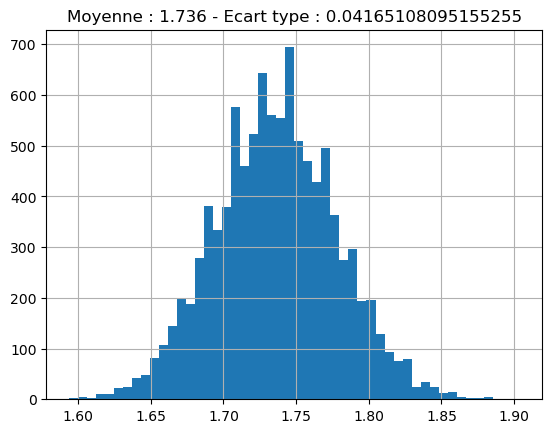

In [329]:
test.hist('tx_art', bins=50)
plt.title('Moyenne : ' + str(np.round(np.mean(test.tx_art),3)) + ' - Ecart type : ' +  str(np.std(test.tx_art)));

In [331]:
test.to_parquet('analyse_aleatoire_bati_31.csv')